![spotify](spotify.jpeg)

<h1><center>Spotify tracks attributes and explanatory analysis</center></h1>

**About Spotify**:<br>

Originally found in Sweden, Spotify became one of the largest worldwide music streaming services. Since  2006 company has been growing its popularity and reached 87 million paying subscribers in November 2018. The large number of Spotify users allowed to create significant content database and retreive valuable patterns from tracks attributes. <br>

For current project we used developers documentation and Web API to access music data, provided by platform. 

**Data**:

We will go through official documentation, using "Search" endpoint reference to collect data, includes:<br>
 - tracks metadata;
 - artists' attributes;
 - audio features.

### Install  libraries, API connection setting

In [4]:
# install Spotipy library to access music datta
import sys
!{sys.executable} -m pip install spotipy

In [2]:
"""
- establish client credentials for authentification

"""
import spotipy 
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [3]:
"""
- will store data into panads data frame
- import visualization libraries for explanatory analysis part

"""

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

%matplotlib inline
from pylab import rcParams

plt.style.use('bmh')

We access data with username and client id of application, registrated on developers page. 
Additionally we need to use token with scope, such as user library/playlist read/modify to retreive tracks and attributes. 

In [ ]:
"""
- we access data with username and client id of application, registrated
- import visualization libraries for explanatory analysis part

"""
 
username='XXXXXX' # Spotify username
scope = 'user-library-read playlist-modify-public playlist-read-private'
client_id='XXXXX' # app-redirect url
client_secret='XXXXXXXXX'

redirect_uri='http://localhost:8888/callback/' # Paste your Redirect URI here
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Token is not accessible", username)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?scope=playlist-modify-public+playlist-read-private+user-library-read&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2Fcallback%2F&response_type=code&client_id=2073a04b9b3c45eeb5473c564e8c6c1e in your browser




### Part 1 - retrieve the tracks' list 

On this stage we will retrieve tracks metadata: artist name, album name, track name, popularity, track id and write into data frame.

In [ ]:
"""
- generate empty lists for related track's characteristics
- using sp.search() will iterate through 2018 tracks, appending items in lists

"""

artist_ids=[]
artist_names=[]
track_names=[]
track_ids=[]
popularity_score=[]

for i in range(0,10000,10):
    res=sp.search(q='year:2018', type='track', offset=i)
    for i, j in enumerate(res['tracks']['items']):
        artist_id = j['artists'][0]['id']
        artist_ids.append(artist_id)
        artist_name = j['artists'][0]['name']
        artist_names.append(artist_name)
        track_name = j['name']
        track_names.append(track_name)
        track_id = j['id']
        track_ids.append(track_id)
        track_popularity = j['popularity']
        popularity_score.append(track_popularity)
# create data frame with lists as columns 
track_attributes = pd.DataFrame({'artist_ids':artist_ids, 'artist_names':artist_names, 'track_names':track_names, 'track_ids':track_ids, 'popularity_score':popularity_score})

### Part 2 - retrieve the artists' genres

However Spotify documentation does not provide the way to look up the genres tags for selected tracks from database. Hence, we will use the same approach to get artists data using Spotify.search().

In [36]:
# create the lists for artists ids and genres tags
artist_ids_genres=[]
genres_all=[]

for i in range(0,10000,10):
    res_genres=sp.search(q='year:2018', type='artist', offset=i)
    for i, j in enumerate(res_genres['artists']['items']):
        artist_id_genre=j['id']
        artist_ids_genres.append(artist_id_genre)
        artist_genre=j['genres']
        genres_all.append(artist_genre)
        
# separate tags with comma          
genres_list = [', '.join(x) for x in genres_all]
genres = pd.DataFrame({'artist_ids':artist_ids_genres, 'genres_all':genres_list})

genres.to_csv('genres.csv')

### Part 3 - retrieve the tracks' features


Additionally we are going to retreive the attributes: energy, liveness, acousticness, instrumentalness, loudness, danceability and valence. Before writing into frame, its worth checking for 'None' values - otherwise, the error can be occured. 

In [14]:
"""
- start with empty list - it will include the sets of all features 
- check for None values 
- write a list into dataframe 

"""
features = []
for i in range(0,len(track_ids)):
    track=str(track_ids[i])
    audio_features = sp.audio_features(track)
    for track in audio_features:
        features.append(track)
# use list comprehension, leave elements that are not None
f = [feat for feat in features if feat is not None]
playlist_df = pd.DataFrame(f)
playlist_df.rename(columns={'id': 'track_ids'}, inplace=True)

playlist_df.head()

### Part 4 - enitire dataframe collection

Finally we merge all collected dataframes in one to prepare for explanatory analysis. 

In [167]:
"""
- merge created dataframe and write csv with utf-8 encoding

"""

artist_genre=pd.merge(track_attributes, genres)
df = pd.merge(artist_genre, playlist_df)
df.to_csv('tracks_data.csv', sep='\t', encoding='utf-8')

Delete columns we don't need for analysis and check NaN values.

In [13]:
"""
- read from csv and and drop NaNs 
- display the shape of frame

"""
df = pd.read_csv('tracks_data.csv', sep='\t', encoding='utf-8')
df.drop(['artist_ids', 'track_ids', 'analysis_url', 'track_href', 'uri', 'key', 'type', 'Unnamed: 0'], axis=1, inplace=True)

df.isna().any()
df.dropna(inplace=True)
df.to_csv('tracks_assignment.csv', sep='\t', encoding='utf-8')
print df.shape
df.head()

(1533, 16)


,artist_names,popularity_score,track_names,genres_all,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Travis Scott,94,SICKO MODE,"pop, pop rap, rap",0.00513,0.834,312820,0.730,0.000000,0.124,-3.714,1,0.2220,155.008,4,0.4460
1,Travis Scott,84,STARGAZING,"pop, pop rap, rap",0.00947,0.487,270715,0.789,0.000004,0.189,-3.690,1,0.0440,150.007,4,0.0564
2,Travis Scott,82,BUTTERFLY EFFECT,"pop, pop rap, rap",0.05310,0.763,190557,0.628,0.000000,0.114,-5.850,1,0.0500,140.958,4,0.1930
3,Sheck Wes,92,Mo Bamba,"hip hop, pop rap, rap, southern hip hop, trap ...",0.19400,0.729,183907,0.625,0.009860,0.248,-5.266,1,0.0315,146.034,4,0.2610
4,Sheck Wes,63,Do That,"hip hop, pop rap, rap, southern hip hop, trap ...",0.26300,0.782,170435,0.508,0.070600,0.157,-7.153,1,0.2310,137.954,4,0.3560


### Explanatory data analysis

We will start describing the dataframe and analysis of popularity score. <br>
As per documentation, the score value ranges from 0 (least popular) to 100 (most popular) and primarily based on number of plays the track achieved. 

In [18]:
df.describe()

,popularity_score,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000
mean,53.730594,0.268491,0.620908,198233.146119,0.613769,0.088421,0.200838,-7.501060,0.604697,0.128242,120.960172,3.920417,0.448897
std,16.608055,0.291296,0.162704,66707.061642,0.214425,0.244395,0.164716,4.371797,0.489075,0.126192,30.978039,0.436796,0.230838
min,0.000000,0.000004,0.086100,16280.000000,0.006330,0.000000,0.029900,-33.545000,0.000000,0.022900,59.090000,1.000000,0.033000
25%,51.000000,0.042900,0.518000,170187.000000,0.482000,0.000000,0.101000,-8.838000,0.000000,0.042400,96.010000,4.000000,0.263000
50%,56.000000,0.154000,0.638000,199187.000000,0.633000,0.000001,0.125000,-6.531000,1.000000,0.067200,119.928000,4.000000,0.428000
75%,63.000000,0.411000,0.743000,223583.000000,0.783000,0.000632,0.258000,-4.748000,1.000000,0.187000,140.055000,4.000000,0.609000
max,96.000000,0.995000,0.985000,599339.000000,0.999000,0.972000,0.977000,-0.999000,1.000000,0.921000,202.200000,5.000000,0.978000


#### Audio fetaures exploration 

How does popularity score relate to other audio features? Is there any correlation between all variables?<br>

Next we will visualize paired correlation between numerical variables.

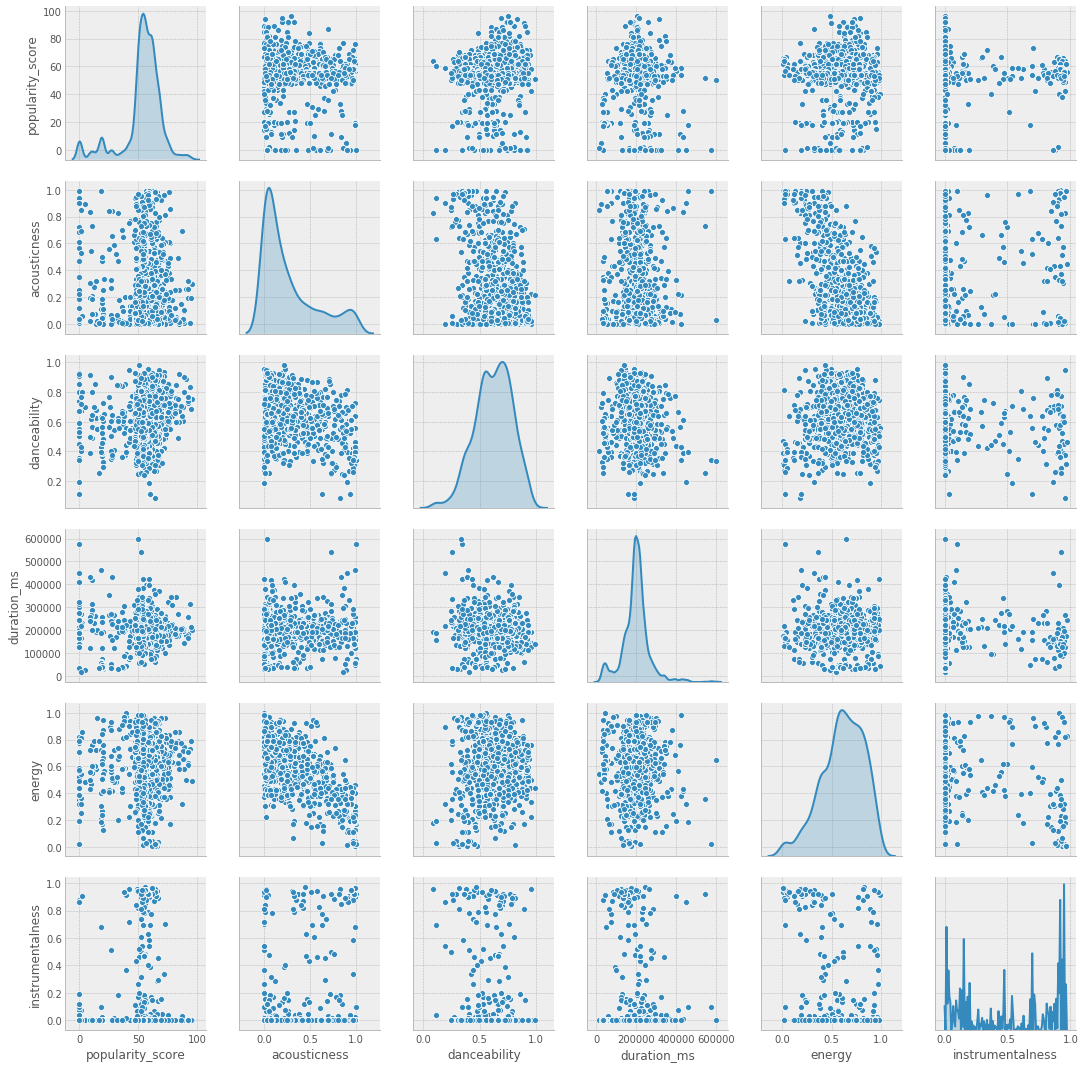

In [27]:
"""
- with seaborn library display pairplots; add density plots on main diagonal 

"""

scatter = sns.pairplot(df[['popularity_score', 'acousticness', 'danceability', 
                           'duration_ms', 'energy', 'instrumentalness']], diag_kind="kde")

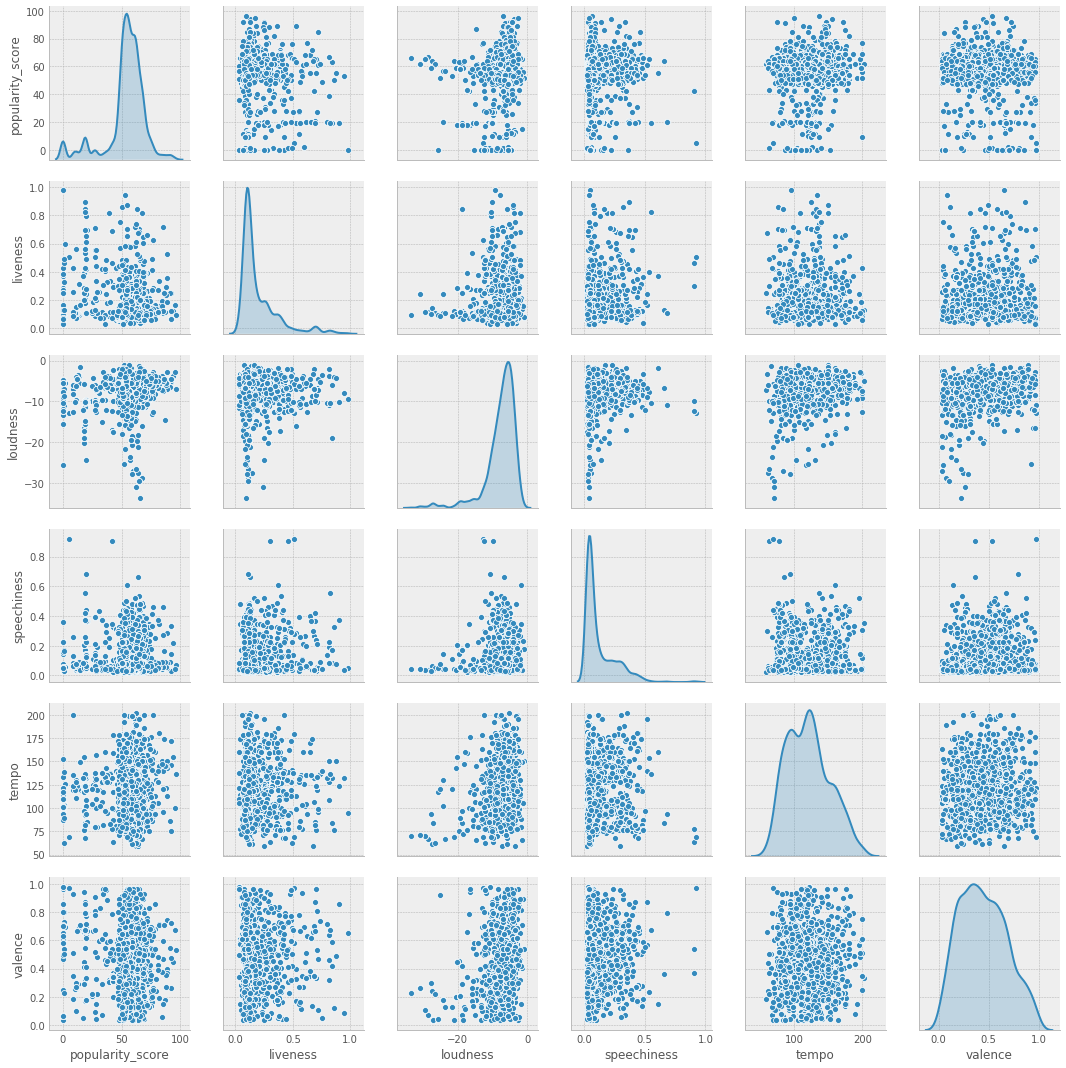

In [28]:
"""
- include popularity score in list to visulaize correlation between rest of variables 

"""
scatter2 = sns.pairplot(df[['popularity_score',
                         'liveness', 'loudness', 'speechiness', 'tempo', 'valence']], diag_kind="kde")

We see few features show high correlation on pairplots. Then, form a heatmap to summarize the correlation ratio.

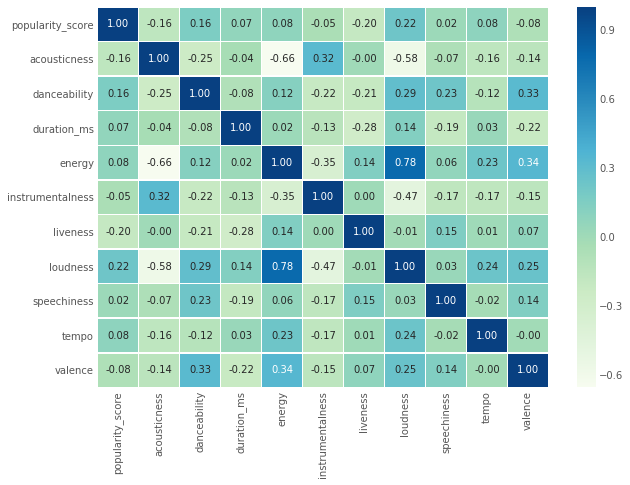

In [29]:
"""
- estimate correlations in matrix form 
- plot seaborn heatmap with annotation bar

"""

numeric=['popularity_score', 'acousticness', 'danceability', 
         'duration_ms', 'energy', 'instrumentalness', 
         'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

matrix = df[numeric].corr()
y, x = plt.subplots(figsize=(9, 7))

sns.heatmap(matrix, annot=True, fmt=".2f", linewidths=.5, cmap="GnBu")
plt.show()

To investigate the correlation for energy-loudness and energy-acousticness pairs we can build jointplots for each combination. 

Text(1,1.2,'Energy-acousticness relation')

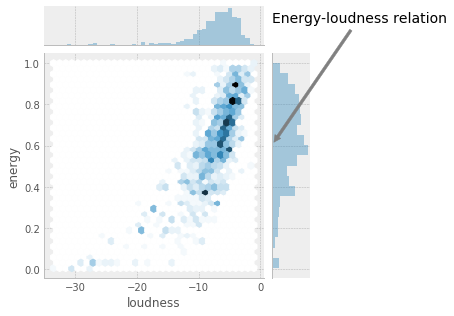

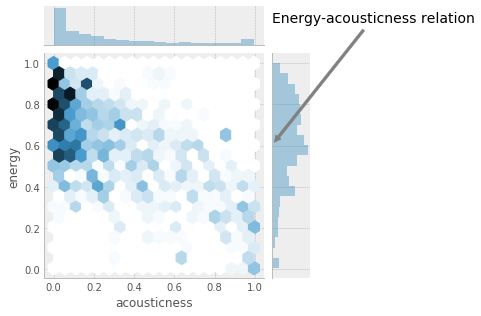

In [30]:
"""
- first, display jointplot
- add annotation bar to plot, specifying properties as 'arrowprops'

"""
# plot for energy-loudness pair 
sns.jointplot(x="loudness", y="energy", data=df, kind="hex", height=4.5)

plt.annotate('Energy-loudness relation',
             xy=[0.1, 0.6],
             xytext=[1, 1.2],
             fontsize=14,
             arrowprops=dict(color='grey',
                             arrowstyle='simple',
                             shrinkA=4,
                             shrinkB=4))

# plot for energy-acousticness pair 
sns.jointplot(x="acousticness", y="energy", data=df, kind="hex", height=4.5)

plt.annotate('Energy-acousticness relation',
             xy=[0.1, 0.6],
             xytext=[1, 1.2],
             fontsize=14,
             arrowprops=dict(color='grey',
                             arrowstyle='simple',
                             shrinkA=4,
                             shrinkB=4))


Paired charts shows the positive correlation character for energy and loudness, while energy-accousticness pair behaves in opposite way: energy goes down as acousticness rate increase. 

#### Artist - Genre exploration 

To continue with explanatory analysis we will summarize popularity score per artist and top 10 least and most popular artists from sample.

In [18]:
artist_df = pd.pivot_table(df, values='popularity_score', index=['artist_names'], aggfunc=np.mean)

artist_df.fillna(0, inplace=True)
# shortlist top 10 artist by popularity
artist_df=artist_df.sort_values(by=['popularity_score'], ascending=False)
artist_df.head(10)

,popularity_score
artist_names,
Paulo Londra,92.000000
Flipp Dinero,89.000000
Ariana Grande,88.000000
Travis Scott,86.666667
Mau y Ricky,86.000000
XXXTENTACION,83.500000
Nicky Jam,82.000000
Lil Uzi Vert,82.000000
BLACKPINK,81.000000


In [19]:
# shortlist 10 least popular 
artist_df.tail(10)

,popularity_score
artist_names,
Otis Redding,0.500
Aretha Franklin,0.200
Donny Hathaway,0.125
Antônio Carlos Jobim,0.000
"Earth, Wind & Fire",0.000
George Benson,0.000
George Frideric Handel,0.000
Mase,0.000
Pnau,0.000


To explore the genres more, we can transform the genres tags into cloud of words and investigate their frequencies. 

In [37]:
df.head()

,artist_names,popularity_score,track_names,genres_all,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Travis Scott,94,SICKO MODE,"pop, pop rap, rap",0.00513,0.834,312820,0.730,0.000000,0.124,-3.714,1,0.2220,155.008,4,0.4460
1,Travis Scott,84,STARGAZING,"pop, pop rap, rap",0.00947,0.487,270715,0.789,0.000004,0.189,-3.690,1,0.0440,150.007,4,0.0564
2,Travis Scott,82,BUTTERFLY EFFECT,"pop, pop rap, rap",0.05310,0.763,190557,0.628,0.000000,0.114,-5.850,1,0.0500,140.958,4,0.1930
3,Sheck Wes,92,Mo Bamba,"hip hop, pop rap, rap, southern hip hop, trap ...",0.19400,0.729,183907,0.625,0.009860,0.248,-5.266,1,0.0315,146.034,4,0.2610
4,Sheck Wes,63,Do That,"hip hop, pop rap, rap, southern hip hop, trap ...",0.26300,0.782,170435,0.508,0.070600,0.157,-7.153,1,0.2310,137.954,4,0.3560


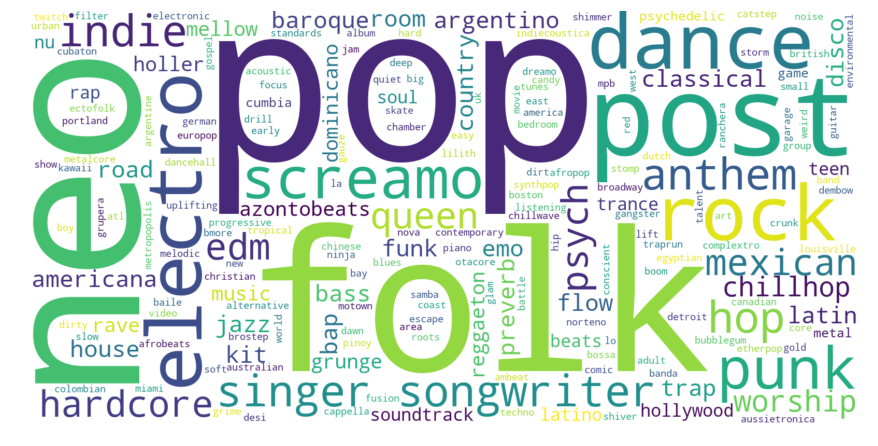

<Figure size 432x288 with 0 Axes>

In [25]:
"""
- generate a column of words counts dictionaries 
- create new frame with columns as separate tags 

"""

df['words_count'] = df.genres_all.apply(lambda x: Counter(x.split(' ')))
gen_table=pd.DataFrame(df.words_count.values.tolist())
gen_table[np.isnan(gen_table)] = 0


"""
- for each review perform transformation into string type
- generate the cloud of words using Wordcloud() module 

"""

# create wordcloud object with gen_table as an argument 
wordcloud = WordCloud(background_color='white', width=1600, height=800).generate(' '.join(gen_table))
# plot as a figure
plt.figure(figsize=(12,8))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('wordclouds.png', bbox_inches='tight')

Finally, let's count some of the most popular tags from WordCloud and represent using bar chart.

Text(0.5,1,'Top genres tags')

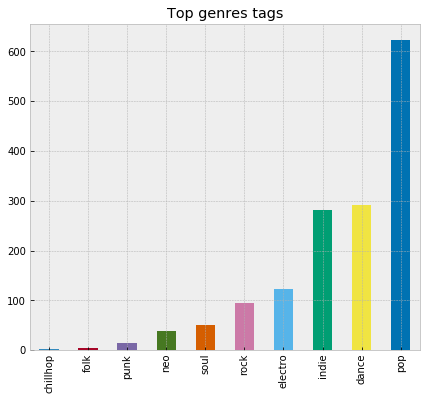

In [30]:
"""
- initialize the list of genres we are interested in 
- apply sorting to display ascending order 

"""

list_g = ['pop', 'folk', 'neo', 'electro', 'punk', 'dance', 'rock', 'soul', 'indie', 'chillhop']

rcParams['figure.figsize'] = 7, 6

gen_table[list_g].sum().sort_values(ascending=True).plot(kind='bar')
plt.title('Top genres tags')